# CS211: Data Privacy
## In-Class Exercise, week of 10/17/2022

In [5]:
# Load the data and libraries
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

def laplace_mech(v, sensitivity, epsilon):
    return v + np.random.laplace(loc=0, scale=sensitivity / epsilon)

def gaussian_mech(v, sensitivity, epsilon, delta):
    return v + np.random.normal(loc=0, scale=sensitivity * np.sqrt(2*np.log(1.25/delta)) / epsilon)

def pct_error(orig, priv):
    return np.abs(orig - priv)/orig * 100.0

adult = pd.read_csv('https://github.com/jnear/cs211-data-privacy/raw/master/homework/adult_with_pii.csv')

In [6]:
def gaussian_mech_RDP(val, sensitivity, alpha, epsilon):
    sigma = np.sqrt((sensitivity**2 * alpha) / (2 * epsilon))
    return val + np.random.normal(loc=0, scale=sigma)

## Question 1

Use the sample-and-aggregate framework to calculate the sum of ages in the adult dataset with differential privacy.

In [7]:
def saa_avg_age(k, epsilon):
    df = adult['Age']

    chunk_size = int(np.ceil(df.shape[0] / k))
    # split the data into chunks
    chunks = [df[i:i + chunk_size] for i in range(0, df.shape[0], chunk_size)]

    # run the query on each chunk
    answers = [chunk.sum() for chunk in chunks]

    # clip the answers with parameter b
    upper = 2500
    lower = 1000
    clipped_answers = np.clip(answers, lower, upper)
    sensitivity = upper - lower

    # sum the clipped answers (sensitivity b)
    sum_result = np.sum(clipped_answers)

    # add noise to the sum (scale = b / epsilon)
    noisy_sum = laplace_mech(sum_result, sensitivity, epsilon)
    return noisy_sum
saa_avg_age(600, 1)    

1257327.953336862

## Question 2

What is the impact of the parameter `k`?

k is the number of chunks, large k means many small (few rows) chunks, small k means few big (many rows) chunks

## Question 3

Calculate the empirical *cumulative distribution function* of ages in the adult dataset. Use the RDP Gaussian mechanism.

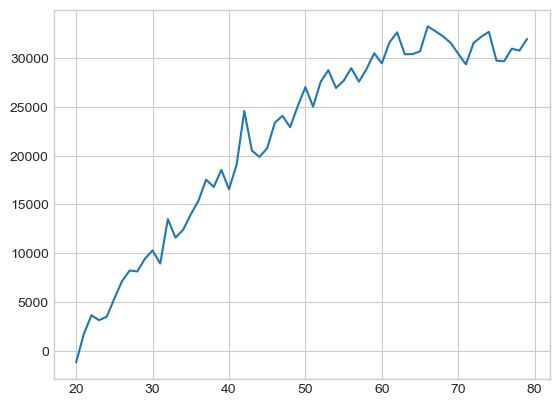

In [10]:
def calculate_cdf():
    alpha = 5 # bigger = more noise
    epsilon = 0.0001 # bigger = less noise
    # typical values are much smaller than the epsilon values in pure-epsilon or (epsilon, delta) DP
    
    true_cdf = [len(adult[adult['Age'] < x]) for x in range(20, 80)]
    noisy_cdf = [gaussian_mech_RDP(x, np.sqrt(60), alpha, epsilon) for x in true_cdf]
    return noisy_cdf

cdf_vals = calculate_cdf()
plt.plot(range(20, 80), cdf_vals);

## Question 4

What is the *total privacy cost* in RDP of your solution above?

We use L2 sensitivity for the CDF vector, eqch query is a counting query so it has a sensitivity 1, thus the total sensitivity is sqrt(60)

We call the gaussian mechanism one time, for a total privacy cost of (alpha, epsilon)-RDP

We immediately return the noisy results

In [11]:
def convert_rdp(alpha, epsilon_bar, delta):
    epsilon = epsilon_bar + (np.log(1/delta) / (alpha - 1))
    return epsilon

convert_rdp(50, .1, 1e-5)

0.3349576625504128

## Question 5

What is the *total privacy cost* in $(\epsilon, \delta)$-differential privacy of your solution above, for $\delta = 10^{-5}$?

the total privacy cost is (2.878, 1e-5)-differential privacy

## Question 6

Repeat question 3, but for zero-concentrated differential privacy.

In [ ]:
def convert_zcdp(rho, delta):
    return rho + np.sqrt(rho * np.log(1/delta))

def gaussian_mech_zCDP(val, sensitivity, rho):
    sigma_sq = sensitivity ** 2 / (2 * rho)
    sigma = np.sqrt(sigma_sq)
    return val + np.random.normal(loc=0, scale = sigma)

def calculate_cdf_zcdp():
    rho = 0.00001
    
    true_cdf = [len(adult[adult['Age'] < x]) for x in range(20, 80)]
    noisy_cdf = [gaussian_mech_zCDP(x, np.sqrt(60), rho) for x in true_cdf]
    return noisy_cdf

cdf_vals = calculate_cdf_zcdp()
plt.plot(range(20, 80), cdf_vals);